In [20]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [21]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [23]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, BatchNormalization, Dropout

In [24]:
## generators : It helps us to handle the bigger datasets to load
train_df = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)

validation_df = keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [25]:
## Normalize the image
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_df = train_df.map(process)
validation_df = validation_df.map(process)

In [26]:
## Create model
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [28]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [29]:
history = model.fit(train_df, epochs=10, validation_data = validation_df)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 77ms/step - accuracy: 0.5673 - loss: 2.1626 - val_accuracy: 0.6220 - val_loss: 0.8681
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.6849 - loss: 0.5928 - val_accuracy: 0.7068 - val_loss: 0.5702
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 74ms/step - accuracy: 0.7559 - loss: 0.5063 - val_accuracy: 0.7504 - val_loss: 0.5126
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 82ms/step - accuracy: 0.7996 - loss: 0.4404 - val_accuracy: 0.6886 - val_loss: 0.6955
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8261 - loss: 0.3937 - val_accuracy: 0.6872 - val_loss: 0.6104
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.8571 - loss: 0.3240 - val_accuracy: 0.7646 - val_loss: 0.5368
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 81ms/step - accuracy: 0.8948 - loss: 0.2454 - val_accuracy: 0.7524 - val_loss: 0.5617
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 75ms/step - accuracy: 0.9331 - loss: 0.1760 - 

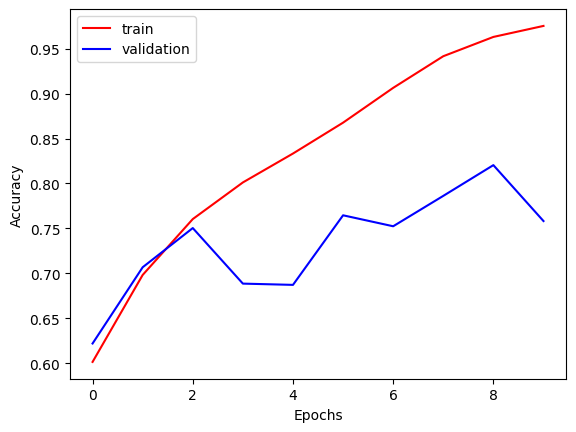

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

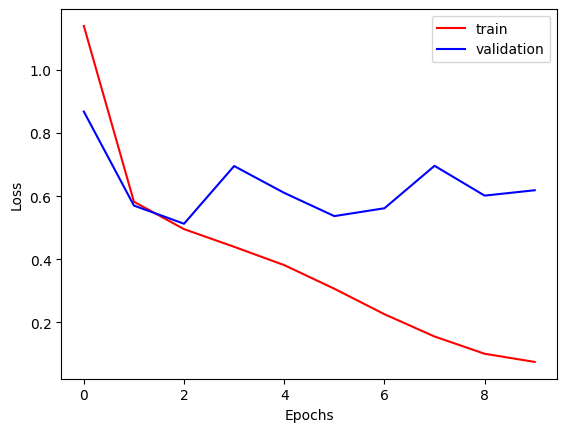

In [31]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As we can see that our model is performing good on training data but loss is increasing with increase in epoch which causes overfitting

In [32]:
## Ways to reduce overfitting

# Add more data
# Data Augmentation
# L1/L2 Regularizer
# Dropout
# Batch Norm
# Reduce Complexity

In [56]:
 import cv2


In [69]:
test_img = cv2.imread('/content/cat.jpg')
test_img2 = cv2.imread('/content/dog2.jpg')

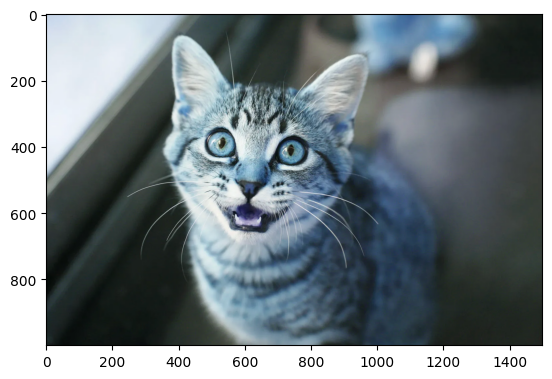

In [70]:
plt.imshow(test_img)

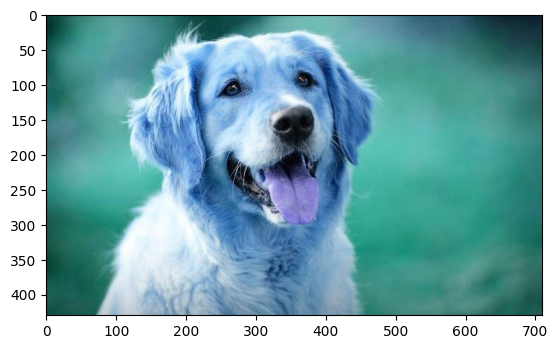

In [71]:
plt.imshow(test_img2)

In [72]:
test_img.shape

(1000, 1499, 3)

In [73]:
test_img2.shape

(430, 710, 3)

In [74]:
test_img = cv2.resize(test_img,(256,256))
test_img2 = cv2.resize(test_img2,(256,256))

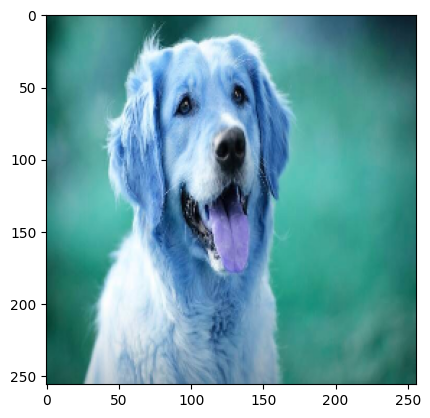

In [75]:
plt.imshow(test_img2)

In [76]:
test_input = test_img.reshape((1,256,256,3))
test_input2 = test_img2.reshape((1,256,256,3))

In [77]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.]], dtype=float32)

In [78]:
model.predict(test_input2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[1.]], dtype=float32)